In [142]:
from surrogate_model.GPRs import GPRs
import pandas as pd
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.problems.functional import FunctionalProblem

file_name = 'LHS180_t1.xlsx'
df = pd.read_excel(file_name)

In [49]:
x_num = 12 # Number of design variables
train_size = int(df.shape[0] * 0.8) # 80% for the train data
x_list = ["DV"+f"{i}" for i in range(x_num)]
y_list = ["CP_case0", "Max_OASPL_case0", "CP_case1", "Max_OASPL_case1"] # Index name of the Objectives/Constraints

x = df[x_list].to_numpy()
y = df[y_list].to_numpy()



In [192]:
class DDO(): # Data-Driven Optimization
    def __init__(self, x, y, pop_size=100):
        self.x, self.y = x, y
        kernel = ConstantKernel() * Matern(nu=2.5)
        self.gpr_models = GPRs(kernel=kernel, n_restarts_optimizer=30, random_state=42, normalize_y=True)
        self.pop = pop_size

    def shuffle(self):

        np.random.seed(42)
        # Data shuffling
        random_idx = np.arange(x.shape[0])
        np.random.shuffle(random_idx)
        x_shuffled, y_shuffled = x[random_idx], y[random_idx]

        # Train-Test split
        self.x_train, self.y_train = x_shuffled[:train_size], y_shuffled[:train_size]
        self.x_test, self.y_test = x_shuffled[train_size:], y_shuffled[train_size:]

        self.x_train = np.delete(self.x_train,[14,50],axis=0)
        self.y_train = np.delete(self.y_train,[14,50],axis=0)

    def fit(self):

        self.gpr_models.fit(self.x_train, self.y_train)

    def predict(self, x=None):

        if x is None: # When the x for the prediction is not given, perform prediction with x_test datatset
            y_pred = self.gpr_models.predict(self.x_test)
        else:
            y_pred = self.gpr_models.predict(x)

        return y_pred

    def plot(self, y_true=None, y_pred=None, y_idx=0):
        if y_true is None:
            y_true = self.y_test[:,y_idx]
        if y_pred is None: # If y_pred is not given, use the prediction from x_test as "y_pred"
            y_pred = self.predict()[:,y_idx]

        sns.set_style("whitegrid")
        sns.set_palette("Set2")
        min_plt, max_plt = np.min([np.min(y_true), np.min(y_pred)]), np.max([np.max(y_true), np.max(y_pred)])
        min_show, max_show = min_plt - 0.1 * (max_plt - min_plt), max_plt + 0.1 * (max_plt - min_plt)
        fig, ax = plt.subplots(dpi=100)
        ax.scatter(y_true, y_pred)
        ax.plot([min_show, max_show], [min_show, max_show])
        ax.set_ylim(min_show, max_show)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("Ground truth", fontsize=17)
        ax.set_ylabel("Prediction", fontsize=17)

        return fig, ax

    def optimize(self):

        problem = self.def_problem()
        algorithm, termination = self.def_algorithm()

        res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=False)

        return res

    def def_problem(self):

        n_var = self.x.shape[1]
        n_obj = n_obj=self.y.shape[1]
        parent_cls = self
        class MyProblem(ElementwiseProblem):

            def __init__(self):
                super().__init__(n_var=n_var,
                                 n_obj=n_obj,
                                 xl=np.array([0]*n_var),
                                 xu=np.array([1]*n_var))

            def _evaluate(self, x, out, *args, **kwargs):
                f = np.hsplit(parent_cls.predict(x.reshape(1,-1)), indices_or_sections=n_obj)
                out["F"] = [f]

        problem = MyProblem()

        return problem

    def def_algorithm(self):

        algorithm = NSGA2(
            pop_size=self.pop,
            eliminate_duplicates=True
        )
        termination = get_termination("n_gen", 40)

        return algorithm, termination

(19, 4)


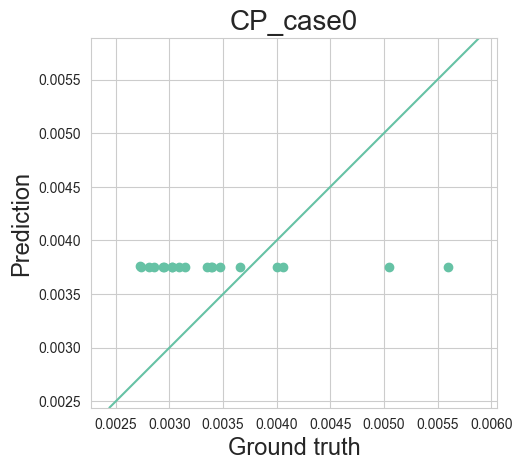

(19, 4)


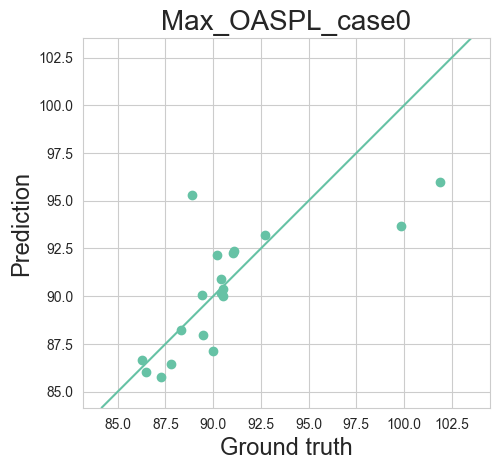

(19, 4)


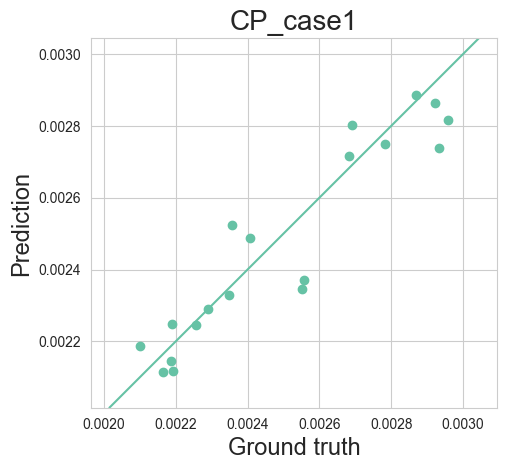

(19, 4)


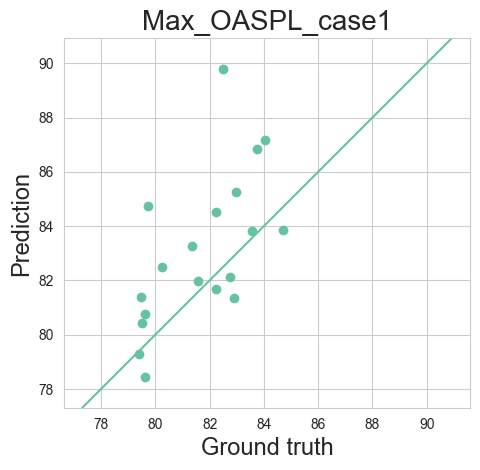

In [193]:
ddo = DDO(x,y, pop_size=100)
ddo.shuffle()
ddo.fit()
for i in range(4):
    fig, ax = ddo.plot(y_idx=i)
    ax.set_title(y_list[i], fontsize=20)
    plt.show()

In [187]:
opt_results = ddo.optimize()

In [191]:
x_optimized = opt_results.X
y_optimized = opt_results.F
write_data = pd.DataFrame(np.concatenate([x_optimized, y_optimized],axis=1))
write_data.columns = x_list + y_list
write_data.to_excel("Pareto.xlsx")